In [ ]:
source_folder = '/content/drive/My Drive/Datasets/binary/'
res_path = '/content/drive/My Drive/Datasets/res/'

In [ ]:
!pip install sklearn
!pip install netcal

# Libraries

In [ ]:
# Libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import precision_recall_fscore_support
from netcal.metrics import ECE

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

## Mount Drive into Colab
from google.colab import drive
drive.mount('/content/drive')

cpu
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data 
training = '10_train_gop_subject_mclass.csv'
testing = '10_test_gop_subject_mclass.csv'
logfile_name = "test_10-hard-lstm-gop_subject-lr10-3-1&2&2&&2&2cw-a02_em500_dr02_maxEp500.csv"

num_classes = 5
class_weight = torch.Tensor([1, 2, 2, 2, 2])
learning_rate = 1e-03
max_epochs = 500
batch_size = 32
embedding_size = 500
dropout_rate =0.2
epoch_eval = 36
iter_eval = 0


# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('text', text_field), ('crowd_label', label_field)]

# TabularDataset

train, test = TabularDataset.splits(path=source_folder, train=training, test=testing, format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=batch_size, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=1, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary
print(train)
text_field.build_vocab(train, min_freq=3)

In [ ]:
# Copyright (C) 2019 Ruhr West University of Applied Sciences, Bottrop, Germany
# AND Visteon Electronics Germany GmbH, Kerpen, Germany
# 
# This Source Code Form is subject to the terms of the Mozilla Public
# License, v. 2.0. If a copy of the MPL was not distributed with this
# file, You can obtain one at http://mozilla.org/MPL/2.0/.

import matplotlib.pyplot as plt
import numpy as np
import logging

from netcal import dimensions, accepts


class ReliabilityDiagram(object):
    """
    Plot Confidence Histogram and Reliability Diagram to visualize miscalibration.

    Parameters
    ----------
    bins : int
        Number of bins. The output space is partitioned into M equally sized bins.

    References
    ----------
    Chuan Guo, Geoff Pleiss, Yu Sun and Kilian Q. Weinberger:
    "On Calibration of Modern Neural Networks."
    arXiv (abs/1706.04599), 2017.
    `Get source online <https://arxiv.org/abs/1706.04599>`_

    A. Niculescu-Mizil and R. Caruana:
    “Predicting good probabilities with supervised learning.”
    Proceedings of the 22nd International Conference on Machine Learning, 2005, pp. 625–632.
    `Get source online <https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf>`_
    """

    @accepts(int)
    def __init__(self, bins: int):
        """
        Constructor.

        Parameters
        ----------
        bins : int
            Number of bins. The output space is partitioned into M equally sized bins.
        """

        self.bins = bins
        self.logger = logging.getLogger('calibration')

    @dimensions((1, 2), 1, None, None)
    def plot(self, X: np.ndarray, y: np.ndarray, title_suffix: str = None, fig_file_name: str = None):
        """
        Plot confidence histogram and reliability diagram to visualize miscalibration.

        Parameters
        ----------
        X : np.ndarray, shape=(n_samples, [n_classes])
            NumPy array with confidence values for each prediction.
            1-D for binary classification, 2-D for multi class (softmax).
        y : np.ndarray, shape=(n_samples,)
            NumPy 1-D array with ground truth labels.
        title_suffix : str, optional, default: None
            Suffix for plot title.
        """

        plt.figure(figsize=(7, 8))

        bins = self.bins
        num_samples = y.size

        title = "Reliability Diagram"

        # -----------------------------------------
        # get prediction labels and sort arrays

        # binary classification problem but got two entries? (probability for 0 and 1 separately)?
        # we only need probability p for Y=1 (probability for 0 is (1-p) )
        if len(X.shape) == 1:

            # first, get right binary predictions (y=0 or y=1)
            predictions = np.where(X > 0.5, 1, 0)

            # calculate average accuracy and average confidence
            total_accuracy = np.equal(predictions, y).sum() / num_samples

            prediction_confidence = np.where(X > 0.5, X, 1. - X)
            total_confidence = np.sum(prediction_confidence) / num_samples

            # plot confidence estimates only for y=1
            # thus, set predictions to 1 for each sample
            predictions = np.ones_like(X)

            title += " for y=1"

        else:

            predictions = np.argmax(X, axis=1)
            X = np.max(X, axis=1)

            # calculate average accuracy and average confidence
            total_accuracy = np.equal(predictions, y).sum() / num_samples
            total_confidence = np.sum(X) / num_samples

        # -----------------------------------------

        # prepare visualization metrics
        bin_confidence = np.zeros(bins)
        bin_accuracy = np.zeros(bins)
        bin_gap = np.zeros(bins)
        bin_samples = np.zeros(bins)
        bin_color = ['blue', ] * bins

        # iterate over bins, get avg accuracy and confidence of each bin and add to ECE
        for i in range(1, bins+1):

            # get lower and upper boundaries
            low = (i - 1) / float(bins)
            high = i / float(bins)
            condition = (X > low) & (X <= high)

            num_samples_bin = condition.sum()
            if num_samples_bin <= 0:
                bin_confidence[i-1] = bin_accuracy[i-1] = (high + low) / 2.0
                bin_color[i-1] = "yellow"
                continue

            # calc avg confidence and accuracy
            right_predictions_bin = np.equal(predictions[condition], y[condition]).sum()
            avg_accuracy = right_predictions_bin / float(num_samples_bin)

            bin_confidence[i-1] = (high + low) / 2.0
            bin_accuracy[i-1] = avg_accuracy
            bin_gap[i-1] = bin_confidence[i-1] - avg_accuracy
            bin_samples[i-1] = num_samples_bin

        bin_samples /= num_samples

        self.logger.info("Average accuracy: %.4f - average confidence: %.4f" % (total_accuracy, total_confidence))

        # -----------------------------------------
        # plot stuff
        ax = plt.subplot(211)

        if title_suffix is not None:
            ax.set_title('Confidence Histogram - ' + title_suffix)
        else:
            ax.set_title('Confidence Histogram')

        plt.bar(bin_confidence, height=bin_samples, width=1. / bins, align='center', edgecolor='black')
        plt.plot([total_accuracy, total_accuracy], [0.0, 1.0], color='black', linestyle='--')
        plt.plot([total_confidence, total_confidence], [0.0, 1.0], color='gray', linestyle='--')
        plt.xlim((0.0, 1.0))
        plt.ylim((0.0, 1.0))

        plt.xlabel('Confidence')
        plt.ylabel('% of Samples')

        plt.legend(['Avg. Accuracy', 'Avg. Confidence', 'Relative Amount of Samples'])

        ax = plt.subplot(212)

        if title_suffix is not None:
            ax.set_title(title + " - " + title_suffix)
        else:
            ax.set_title(title)

        plt.bar(bin_confidence, height=bin_accuracy, width=1./bins, align='center', edgecolor='black')
        plt.bar(bin_confidence, height=bin_gap, bottom=bin_accuracy, width=1./bins, align='center',
                edgecolor='black', color='red', alpha=0.6)

        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlim((0.0, 1.0))
        plt.ylim((0.0, 1.0))

        plt.xlabel('Confidence')
        plt.ylabel('Accuracy')

        plt.legend(['Perfect Calibration', 'Output', 'Gap'])
        plt.tight_layout()
        plt.savefig(source_folder + fig_file_name + '.pdf')
        # from google.colab import files
        # files.download(title_suffix + '.pdf') 
        print('Fig saved!')
        plt.show()

In [ ]:
#bidirectional LSTM model
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), embedding_size)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=embedding_size,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=dropout_rate)

        self.fc = nn.Linear(2*dimension, num_classes)


    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        #text_fea = torch.squeeze(text_fea, 1)
        #text_out = torch.sigmoid(text_fea)

        return text_fea

def smooth_labels(crowd_labelList, conf0, conf1, conf2, con3, conf4, alpha):
    y = np.column_stack((conf0.tolist(), conf1.tolist(), conf2.tolist(), conf3.tolist(), conf4.tolist()))
    for ind in range(len(y)):
        crowd_label = int(crowd_labelList[ind])
        for index in range(len(y[ind])):
          if index == crowd_label:
              y[ind][index] = 1 - alpha + alpha / num_classes
              pass
          else:
              y[ind][index] = alpha / num_classes
    return y

class CrossEntropyLossSoft(nn.Module):

    def __init__(self, weight=None):
        super(CrossEntropyLossSoft, self).__init__()
        self.weight = weight

    def forward(self, pred, soft_targets):
        logsoftmax = nn.LogSoftmax()
        if self.weight is not None:
            return torch.mean(torch.sum(- soft_targets * self.weight * logsoftmax(pred), 1))
        else:
            return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

def ece_score(y_true, y_prob, n_bins=10):
    ece = ECE(n_bins)
    ece_val = ece.measure(y_prob, y_true)

    return ece_val


def compute_val(title_suffix, fig_file_name):
    loss_function = nn.CrossEntropyLoss()
    with torch.no_grad():
        model.eval()
        y_pred = []
        output_prob_val = []
        output_logits_val = []
        y_val_hard = []
        
        for ((text, text_len), labels), _ in test_iter: 
            y_val_hard.append(int(labels.item()))
            sent = text.to(device)
            sent_len = text_len.to(device)
            label = labels.to(device)
            output = model.forward(sent, text_len)
            logit, predicted = torch.max(output.data, 1)
            output_logits_val.append(output[0].cpu().tolist())
            output_prob_val.append(torch.sigmoid(output[0]).cpu().tolist())
            y_pred.append(predicted.item())
        loss_val = loss_function(torch.Tensor(output_logits_val), torch.LongTensor(y_val_hard)).item()
        model.train()
        ece_val = ece_score(np.array(y_val_hard), np.array(output_prob_val))

        # compute and plot ECE
        ece_val = ece_score(np.array(y_val_hard), np.array(output_prob_val))
        n_bins = 10
        diagram = ReliabilityDiagram(n_bins)
        diagram.plot(np.array(output_prob_val), np.array(y_val_hard), title_suffix, fig_file_name)

        # check if binary or multi class classification
        num_classes = len(set(y_val_hard))
        if num_classes == 2:
            average = 'binary'
        else:
            average = 'macro'
        pre_val, rec_val, f1_val, _ = precision_recall_fscore_support(y_val_hard, y_pred, average=average, beta=1)
        _, _, f01_val, _ = precision_recall_fscore_support(y_val_hard, y_pred, average=average, beta=0.1)
        _, _, f10_val, _ = precision_recall_fscore_support(y_val_hard, y_pred, average=average, beta=10)
        print('Iteration: {}. Train Loss: {:1.5f}. Val Loss: {:1.5f}, F1: {:1.3f}, ECE: {:1.3f}, Precision: {:1.3f}, Recall: {:1.3f}'.
            format(i, loss.item(), loss_val, f1_val, ece_val, pre_val, rec_val))
        # print to result file
        with open(res_path, 'a') as f:
            res_i = '{}, {}, {}, {}, {}, {}, {}, {}, {}, {}\n'.format(epoch, i, loss.item(), loss_val, pre_val, rec_val,
                                                                      f01_val, f1_val, f10_val, ece_val)
            f.write(res_i)

EPOCH -- 0
EPOCH -- 1
EPOCH -- 2
EPOCH -- 3
EPOCH -- 4
EPOCH -- 5
EPOCH -- 6
EPOCH -- 7
EPOCH -- 8
EPOCH -- 9
EPOCH -- 10
EPOCH -- 11
EPOCH -- 12
EPOCH -- 13
EPOCH -- 14
EPOCH -- 15
EPOCH -- 16
EPOCH -- 17
EPOCH -- 18
EPOCH -- 19
EPOCH -- 20
EPOCH -- 21
EPOCH -- 22
EPOCH -- 23
EPOCH -- 24
EPOCH -- 25
EPOCH -- 26
EPOCH -- 27
EPOCH -- 28
EPOCH -- 29
EPOCH -- 30
EPOCH -- 31
EPOCH -- 32
EPOCH -- 33
EPOCH -- 34
EPOCH -- 35
EPOCH -- 36
Fig saved!


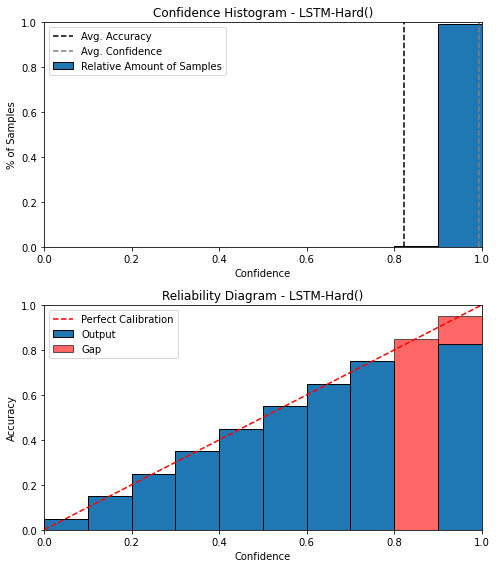

Iteration: 0. Train Loss: 0.00302. Val Loss: 0.90229, F1: 0.823, ECE: 0.172, Precision: 0.830, Recall: 0.825
Model Evaluated!
EPOCH -- 37
EPOCH -- 38
EPOCH -- 39
EPOCH -- 40
EPOCH -- 41
EPOCH -- 42
EPOCH -- 43
EPOCH -- 44
EPOCH -- 45
EPOCH -- 46
EPOCH -- 47
EPOCH -- 48
EPOCH -- 49
EPOCH -- 50
EPOCH -- 51
EPOCH -- 52
EPOCH -- 53
EPOCH -- 54
EPOCH -- 55
EPOCH -- 56
EPOCH -- 57
EPOCH -- 58
EPOCH -- 59
EPOCH -- 60
EPOCH -- 61
EPOCH -- 62
EPOCH -- 63
EPOCH -- 64
EPOCH -- 65
EPOCH -- 66
EPOCH -- 67
EPOCH -- 68
EPOCH -- 69
EPOCH -- 70
EPOCH -- 71
EPOCH -- 72
EPOCH -- 73
EPOCH -- 74
EPOCH -- 75
EPOCH -- 76
EPOCH -- 77
EPOCH -- 78
EPOCH -- 79
EPOCH -- 80
EPOCH -- 81
EPOCH -- 82
EPOCH -- 83
EPOCH -- 84
EPOCH -- 85
EPOCH -- 86
EPOCH -- 87
EPOCH -- 88
EPOCH -- 89
EPOCH -- 90
EPOCH -- 91
EPOCH -- 92
EPOCH -- 93
EPOCH -- 94
EPOCH -- 95
EPOCH -- 96
EPOCH -- 97
EPOCH -- 98
EPOCH -- 99
EPOCH -- 100
EPOCH -- 101
EPOCH -- 102
EPOCH -- 103
EPOCH -- 104
EPOCH -- 105
EPOCH -- 106
EPOCH -- 107
EPOCH -- 108
E

In [ ]:
# create log file
res_path += logfile_name
with open(res_path, 'w') as f:
    c = 'epoch, iter, loss_train, loss_val, pre_val, rec_val, f01_val, f1_val, f10_val, ece_val'
    f.write(c + '\n')

model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss(weight=class_weight.to(device))
train_loader = train_iter
test_loader = test_iter

# training loop
model.train()
for epoch in range(max_epochs):
    print("EPOCH -- {}".format(epoch))
    i = 0
    for ((text, text_len), labels), _ in train_loader:   
        optimizer.zero_grad()
        labels = labels.long().to(device)

        text = text.to(device)
        text_len = text_len.to(device)
        output = model.forward(text, text_len)

        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()

        if (epoch == epoch_eval) and (i == iter_eval):
          compute_val('LSTM-Hard()', 'LSTM-Hard' + logfile_name)
          print('Model Evaluated!')
          break
  
        i = i + 1